# Gipps Model Notebook (Done)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from data.param_data_loader2 import ParamDL2
dataset = ParamDL2()

dataset.summarize()

Datast Loaded. Preview of dataset: 
   driver  trip  congestion  cf_idx  type    time   speed  distance  \
0       1    53           0       0     0  1698.8  6.3472   33011.0   
1       1    53           0       0     0  1698.9  6.3194   33012.0   
2       1    53           0       0     0  1699.0  6.3083   33013.0   
3       1    53           0       0     0  1699.1  6.2556   33013.0   
4       1    53           0       0     0  1699.2  6.2389   33014.0   

   accelpedal  brakepedal  ...  timeHeadway  VL_theta  VL_dtheta  lv_speed  \
0         0.0           1  ...     2.294240  0.137128   0.009974    5.2847   
1         0.0           1  ...     2.304333  0.137128   0.009974    5.2569   
2         0.0           1  ...     2.278744  0.138907   0.009632    5.3083   
3         0.0           1  ...     2.277959  0.140121   0.009801    5.2556   
4         0.0           1  ...     2.264021  0.141357   0.010598    5.1764   

     lv_Ax  distanceCalibrated   lv_distance  timeSinceCF  distanceS

In [3]:
# Import models, before other cells, so there is no need to rerun some tests
from param_models import *
model = BatchGipps(dataset, seqs=["jam"], mode='gpu')

In [4]:
import time
# Test using RMSE over Gap
objective = "s_ego_pred_rmsne"

# Simulate and verify that it works
def_params = model.hyperparams.from_default(device=model.device)

# Simulate
t_s = time.perf_counter()
model.simulate(def_params, batch_size=1, pbar=True)
print(f"{model.model_name} simulated in", time.perf_counter()-t_s, "seconds")

# Compute Stats
t_s = time.perf_counter()
stats = model.compute_stats(objective)
print(f"{model.model_name} stats computed in", time.perf_counter()-t_s, "seconds")
print("Baseline parameters produced", objective, "=", stats["jam_"+objective+"_min"])

print(f"Graphing {model.model_name}")
seqs = model.get_seqs(num_samples=0,groups=["jam"], method="sequential")
model.plot_sim_results(seqs,out_dir="results/"+model.model_name+"_default", label="default", show=False, debug=False)

100%|██████████| 6268/6268 [00:05<00:00, 1209.75it/s]


Gipps simulated in 5.1845505079836585 seconds
Gipps stats computed in 0.03407053300179541 seconds
Baseline parameters produced s_ego_pred_rmsne = tensor(1.7249, device='cuda:0')
Graphing Gipps


100%|██████████| 60/60 [00:33<00:00,  1.77it/s]


In [5]:
RETUNE = True

# best_params = [ 5.04572353, -6.35364589,  1.02,       49.99725976,  3.96971216, -8.19400512]  # From a previous tune cycle
best_params = [  3.48966739, -10.,           1.02,        12.48262406,   1.76587988, -9.43270933]
objective = "s_ego_pred_rmsne"

if RETUNE == True:
    best_params = model.ga_calibrate(objective, "jam", sol_size=1024, batch_size=256, num_generations=500)

opt_params = model.hyperparams.from_array(best_params, model.device)
model.simulate(opt_params, batch_size=1)
stats = model.compute_stats(objective)

seqs = model.get_seqs(num_samples=0,groups=["jam"], method="sequential")
model.plot_sim_results(seqs, out_dir="results/"+model.model_name+"_overall_optimized", label="overall_best", show=False, debug=False)

Generations Progress:   0%|          | 0/500 [00:00<?, ?it/s]/miniconda/envs/SURE/lib/python3.11/site-packages/pygad/pygad.py:728: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resulted in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(
/miniconda/envs/SURE/lib/python3.11/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


GA Optimizing with batch size 256


Generations Progress: 100%|██████████| 500/500 [2:12:34<00:00, 15.91s/it]  

GA found minimized s_ego_pred_rmsne for Gipps at 0.4216262698173523
- Parameters found: [  3.48966739 -10.           1.02        12.48262406   1.76587988
  -9.43270933]



100%|██████████| 60/60 [00:37<00:00,  1.62it/s]


100%|██████████| 6/6 [02:40<00:00, 26.67s/it]

Plotting Per-Param Optimize Result


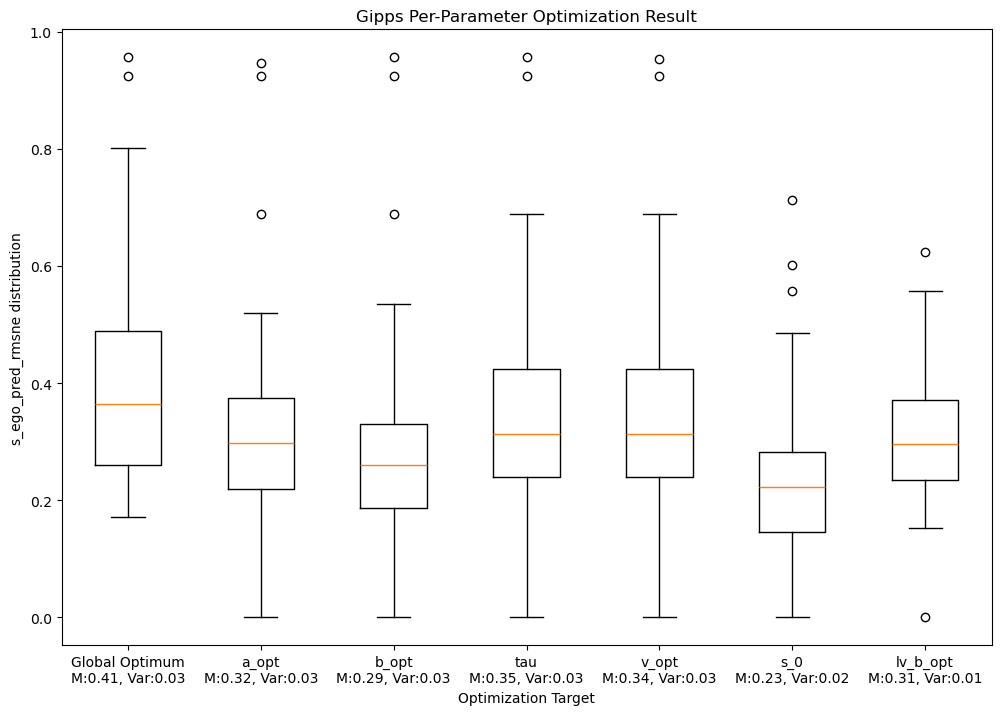

<Figure size 640x480 with 0 Axes>

In [6]:
objective = "s_ego_pred_rmsne"
opt_dict = model.per_param_optimize(best_params, objective)
model.plot_per_param_opt_overview(opt_dict)

In [7]:
model.plot_per_param_opt_indv(opt_dict, best_idx=5)

100%|██████████| 60/60 [00:36<00:00,  1.67it/s]
